# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
# # # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )

# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

# df=cur.fetch_pandas_all()
# df.head()

In [3]:
silver = pd.read_csv('Acuity.csv')
gold_sub = pd.read_csv('GOLD.csv')

## Acuity

In [4]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(23981, 20)

In [5]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)
# silver_acuity.isnull().sum()

In [6]:
silver_acuity.shape

(23981, 8)

In [7]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      19913
Hair Mineral Analysis Appointment       2985
Follow Up Consultation                   544
Customer consultation                    201
Case Study                                41
Hair Mineral Analysis - Acquisition       19
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [8]:
silver_acuity['EVENT'].value_counts()

appointment_changed        17811
appointment_scheduled       5097
appointment_rescheduled      649
appointment_canceled         424
Name: EVENT, dtype: int64

In [9]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4982
Name: EVENT, dtype: int64

In [10]:
# # drop irrelevant appointments
# na_dict= {'True' : np.nan}

# silver_acuity['APPOINTMENT_BODY_CANCELED'].replace(na_dict, inplace = True)
# silver_acuity.dropna(inplace = True)
# # silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    4981
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [11]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis - Acquisition':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    4205
Hair Mineral Analysis Appointment     596
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [12]:
silver_acuity.shape

(4801, 8)

In [13]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     4204
False     597
Name: Complete, dtype: int64

In [14]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    4204
Name: Complete, dtype: int64

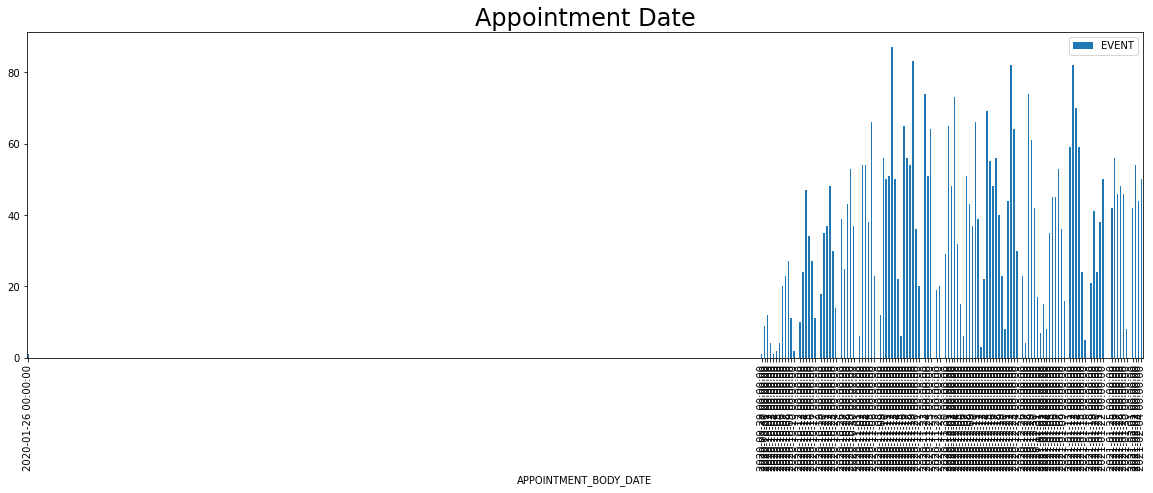

In [15]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

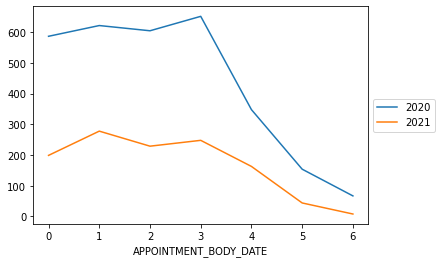

In [16]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.year])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [17]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-01-26 00:00:00')

In [18]:
# min(silver_acuity['APPOINTMENT_BODY_DATE'])
# max(silver_acuity['APPOINTMENT_BODY_DATE'])

# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
clean_acuity.shape

(3637, 10)

In [19]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    3277
Hair Mineral Analysis Appointment     360
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [20]:
#QA instances
smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  3637


## SUB

In [44]:
# Create a copy of the dataframe
gold = gold_sub.copy()

# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])

gold.columns

Index(['EMAIL', 'ITEM_GENDER', 'ITEM_SUB_TYPE', 'ITEM_PRODUCT_CORE_CATEGORY',
       'FIRST_ORDER_AT', 'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE',
       'GROSS_ORDER_VALUE'],
      dtype='object')

In [45]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736630 entries, 0 to 736629
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   EMAIL                       736630 non-null  object        
 1   ITEM_GENDER                 695775 non-null  object        
 2   ITEM_SUB_TYPE               695775 non-null  object        
 3   ITEM_PRODUCT_CORE_CATEGORY  695650 non-null  object        
 4   FIRST_ORDER_AT              736630 non-null  datetime64[ns]
 5   TOTAL_ORDERS                736630 non-null  int64         
 6   TOTAL_ORDER_VALUE           736630 non-null  float64       
 7   GROSS_ORDER_VALUE           695830 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 45.0+ MB


In [46]:
gold.dropna(inplace = True)
gold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695650 entries, 0 to 736629
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   EMAIL                       695650 non-null  object        
 1   ITEM_GENDER                 695650 non-null  object        
 2   ITEM_SUB_TYPE               695650 non-null  object        
 3   ITEM_PRODUCT_CORE_CATEGORY  695650 non-null  object        
 4   FIRST_ORDER_AT              695650 non-null  datetime64[ns]
 5   TOTAL_ORDERS                695650 non-null  int64         
 6   TOTAL_ORDER_VALUE           695650 non-null  float64       
 7   GROSS_ORDER_VALUE           695650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 47.8+ MB


In [47]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

shape =  (695650, 8)
unique emails =  21602


In [82]:
gold.loc[gold['EMAIL']=='101akpatel@gmail.com']

,EMAIL,ITEM_GENDER,ITEM_SUB_TYPE,ITEM_PRODUCT_CORE_CATEGORY,FIRST_ORDER_AT,TOTAL_ORDERS,TOTAL_ORDER_VALUE,GROSS_ORDER_VALUE


In [60]:
# Aggregate
# bydate=df.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
# bydate.head()

df = gold.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE': 'mean',\
                                'TOTAL_ORDERS': 'mean'\
                                ,'ITEM_GENDER': 'last',\
                                'ITEM_SUB_TYPE': 'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY': 'last'\
                               })
df.shape

(21602, 6)

<AxesSubplot:ylabel='EMAIL'>

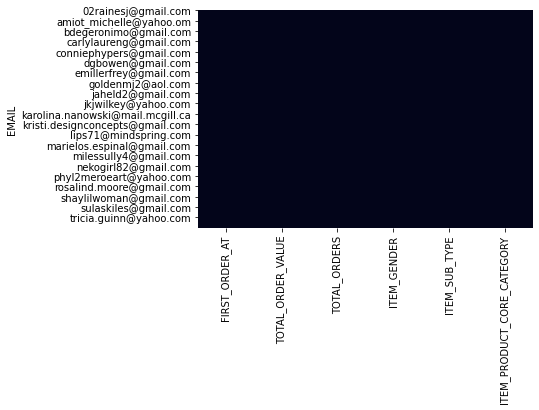

In [61]:
sns.heatmap(df.isnull(), cbar=False)

In [62]:
df.shape

(21602, 6)

In [63]:
df_total = df['TOTAL_ORDER_VALUE'].mean()
print('Subscription Total Order Value = ',df_total)

df_orders = df['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_orders)

Subscription Total Order Value =  1251.871685954988
Subscription Total Orders =  15.413248773261735


In [64]:
df.dropna().describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,21602.000000,21602.000000
mean,1251.871686,15.413249
std,760.112543,9.287685
min,0.000000,1.000000
25%,638.000000,8.000000
50%,1092.000000,13.000000
75%,1786.000000,22.000000
max,7847.000000,93.000000


In [75]:
df.head()

,FIRST_ORDER_AT,TOTAL_ORDER_VALUE,TOTAL_ORDERS,ITEM_GENDER,ITEM_SUB_TYPE,ITEM_PRODUCT_CORE_CATEGORY
EMAIL,,,,,,
02rainesj@gmail.com,2018-06-29 07:27:20,1222.0,14,Men,GrowthPlan,Men
1.amy.l.jones@gmail.com,2018-09-30 13:48:15,561.0,4,Women,GrowthPlan 3,Women
11513chick@gmail.com,2018-10-08 18:35:39,2020.0,25,Women,GrowthPlan,Women
11eglende@gmail.com,2018-11-17 03:38:44,638.0,4,Women,GrowthPlan,Women
11gennaro@gmail.com,2018-07-30 01:40:36,1620.8,20,Men,GrowthPlan,Men


## Merge

In [86]:
sub1 = pd.merge(gold,clean_acuity,how='left',on='EMAIL')
sub1.shape

(695650, 17)

In [85]:
# sns.heatmap(sub1.isnull(), cbar=False)

In [81]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL', 'FIRST_ORDER_AT','APPOINTMENT_BODY_DATE',\
           'ITEM_PRODUCT_CORE_CATEGORY', 'ITEM_SUB_TYPE','ITEM_GENDER',\
           'TOTAL_ORDERS','TOTAL_ORDER_VALUE']]

sub.head()

,EMAIL,APPOINTMENT_BODY_DATE,FIRST_ORDER_AT,ITEM_PRODUCT_CORE_CATEGORY,ITEM_SUB_TYPE,ITEM_GENDER,TOTAL_ORDERS,TOTAL_ORDER_VALUE
0,101akpatel@gmail.com,2020-12-18,NaT,NaN,NaN,NaN,NaN,NaN
1,11consesa@gmail.com,2020-11-17,NaT,NaN,NaN,NaN,NaN,NaN
2,1christinegallegos@gmail.com,2021-01-22,NaT,NaN,NaN,NaN,NaN,NaN
3,22reverie@gmail.com,2020-11-05,NaT,NaN,NaN,NaN,NaN,NaN
4,2reachmari@gmail.com,2021-01-12,NaT,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

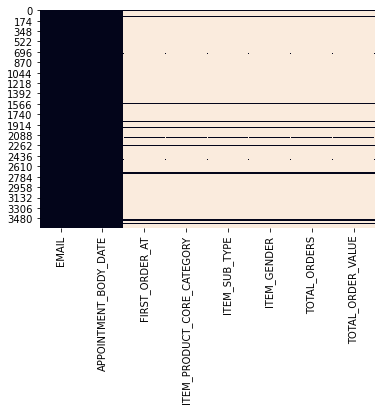

In [ ]:
df_total = df['TOTAL_ORDER_VALUE'].mean()
sub_total = sub['TOTAL_ORDER_VALUE'].mean()
print('Subscription Total Order Value = ',df_total)
print('Sub + Consult Total Order Value = ',sub_total)

df_orders = df['TOTAL_ORDERS'].mean()
sub_total = sub['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_orders)
print('Sub + Consult Total Orders = ',sub_total)

In [ ]:
sub['FIRST_ORDER_AT']=pd.to_datetime(sub['FIRST_ORDER_AT'])

sub['TimeDifference'] = \
(((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))

submail = sub['EMAIL'].nunique()
print ('unique emails = ',submail)

In [ ]:
# clean up item sub
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Prepay 6', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan ', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 3']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,Non-Sub']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 2']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3']= 'Combination'

sub['ITEM_SUB_TYPE'].value_counts()

In [ ]:
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Men']= 'Women'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Combination']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Balance']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Men']= 'Men'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Balance,Men']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Women,Women']= 'Women'

sub['ITEM_PRODUCT_CORE_CATEGORY'].value_counts()

In [ ]:
# # clean up item gender
# gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men,Women,Men,Men,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Men']= 'Women'

sub['ITEM_GENDER'].value_counts()

In [ ]:
# Export data
sub.to_csv('sub.csv')